In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rank_metrics import mean_reciprocal_rank, mean_average_precision, ndcg_at_k
from utils import import_data

DATA_DIR = '../data'

In [2]:
train = import_data(DATA_DIR)

Imported 881052 lines from 31 files


# Algolia Search performance metrics

This section evaluate Algolia Search performance when a click is performed.

Metrics functions are coming from https://gist.github.com/bwhite/3726239.
Due to time constraints, these metrics have not been formely tested 😕.

In [3]:
# Build a click matrix to compute perf metrics
clicks_matrix = []
for index, row in train.iterrows():
    if isinstance(row['clicks'], list) and row['clicks']:
        if row['nb_hits']:
            try:
                _array = np.zeros(row['nb_hits'])
                for click in row['clicks']:
                    _array[click['position'] - 1] = 1
                clicks_matrix.append(_array)
            except:
                pass # Some case are not working => parsing errors ?

### Mean reciprocal rank
https://en.wikipedia.org/wiki/Mean_reciprocal_rank

In [4]:
mean_reciprocal_rank(clicks_matrix)

0.5335751463744777

### Mean Average Precision
https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision

In [ ]:
mean_average_precision(clicks_matrix)

0.5168622744145244

## Algolia search performance metrics for learning to rank experiment
These metrics are computed on the same dataframe as Ml experiments in order to have comparative metrics

In [3]:
train['nb_clicks'] = train['clicks'].apply(
    lambda x: len(x) if isinstance(x, list) else 0)
train = train[train['nb_clicks'] > 0]

train['nb_hits_displayed'] = train['hits'].apply(
    lambda x: len(x) if isinstance(x, list) else 0)
train = train[train['nb_hits_displayed'] > 1]

In [4]:
# Build a click matrix to compute perf metrics
clicks_matrix = []
for index, row in train.iterrows():
    if isinstance(row['clicks'], list) and row['clicks']:
        if row['nb_hits']:
            try:
                _array = np.zeros(row['nb_hits'])
                for click in row['clicks']:
                    _array[click['position'] - 1] = 1
                clicks_matrix.append(_array)
            except:
                pass

### Mean reciprocal rank

In [7]:
mean_reciprocal_rank(clicks_matrix)

0.53245333868448

### Mean average precision

In [ ]:
mean_average_precision(clicks_matrix)

### NDCG @ 1, 3, 5 and 10

In [ ]:
for i in [1, 3, 5, 10]:
    ndcg_ = []
    for query in clicks_matrix:
        ndcg_.append(ndcg_at_k(query, i))
    print('> nDCG@{} is : {}'.format(i, pd.Series(ndcg_).mean()))

> nDCG@1 is : 0.3703725613146717
> nDCG@3 is : 0.5405309873982475
> nDCG@5 is : 0.5940561314277883
> nDCG@10 is : 0.651713595502914


### Metrics comparison with ML experiments
This is a simple plot to compare Learning-to-rank metrics on algolia search and proposed ML experiments, metrics are coming from `rank_xgboost.py` and `rank_tensorflow.py`.

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


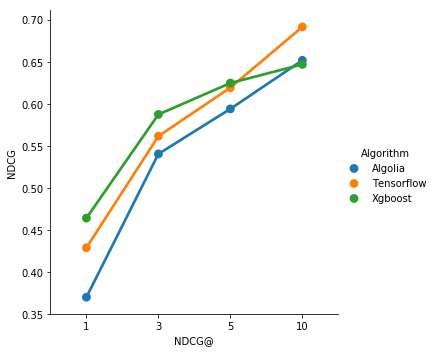

In [12]:
df = pd.DataFrame({'NDCG@':[1, 3, 5, 10],
                   'Algolia':[0.3703, 0.5405, 0.5940, 0.6517],
                   'Tensorflow':[0.4291, 0.5616, 0.6192, 0.6914],
                   'Xgboost':[0.4643, 0.5874, 0.6247, 0.6469]})
df = df.melt('NDCG@', var_name='Algorithm',  value_name='NDCG')
g = sns.factorplot(x="NDCG@", y="NDCG", hue='Algorithm', data=df)